I this section, I'll be using a random forest regression to predict the magnetic moment. I will also be using a leave one out cross validation technique

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn import metrics

%store -r magnetic_data_ohe

In [2]:
# import X and Y data
estimator = magnetic_data_ohe.loc[:, magnetic_data_ohe.columns != 'Magnetic Moment']
predictor = magnetic_data_ohe.loc[:, magnetic_data_ohe.columns == 'Magnetic Moment']

In [3]:
# Split test and train
X_train, X_test, y_train, y_test = model_selection.train_test_split(estimator, predictor, test_size=0.25, random_state=24601)
y_train = y_train.as_matrix(); y_test = y_test.as_matrix();
X_train = X_train.as_matrix(); X_test = X_test.as_matrix();

In [4]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV

In [5]:
# What are the best hyperparameters for the random forest?
param_grid = {"n_estimators": [50, 100, 150],
    "max_depth": [3, None],
    "max_features": [1,2,3,4],
    "min_samples_split": [2, 4, 6, 8],
    "min_samples_leaf": [1, 3, 5, 10],
    "bootstrap": [True, False]}

model = RandomForestRegressor(random_state=24601)
    # oob_score = True, doesn't work when passsed to GridSearchCV
loocv = LeaveOneOut()

grid = GridSearchCV(estimator = model,
                    param_grid = param_grid,
                    n_jobs = -1,
                    scoring = 'neg_mean_squared_error')

grid.fit(X_train, y_train.ravel());

In [6]:
print('Best CV score from the grid:', grid.best_score_)
print(grid.best_params_)

Best CV score from the grid: -0.480397250281
{'bootstrap': False, 'max_depth': None, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 50}


In [7]:
# I'm a bit skeptical of how much the hyperparameter optimization improved given how small my data set is
# and how the default parameters are suppose to be pretty good. I'm going to compare the default and optimized models. 
rf_default = RandomForestRegressor(random_state=24601)
results_default = rf_default.fit(X_train, y_train.ravel())

rf_optimized = RandomForestRegressor(n_estimators = 50,
                                     bootstrap = False,
                                     max_depth = None,
                                     max_features = 4,
                                     min_samples_leaf = 1,
                                     min_samples_split = 4,
                                     random_state = 24601)
results_optimized = rf_optimized.fit(X_train, y_train.ravel())

In [8]:
cv_score = [0,1]
cv_score[0] = model_selection.cross_val_score(rf_default, X_train, y_train.ravel(), cv = loocv, scoring = 'neg_mean_squared_error')
cv_score[1] = model_selection.cross_val_score(rf_optimized, X_train, y_train.ravel(), cv = loocv, scoring = 'neg_mean_squared_error')

In [9]:
print('Default model CV mean:', -cv_score[0].mean())
print('Optimized model CV mean:', -cv_score[1].mean())

Default model CV mean: 0.465696238496
Optimized model CV mean: 0.296175085297


In [10]:
print('Default model CV Varience:', cv_score[0].var())
print('Optimized model CV Varience:', cv_score[1].var())

Default model CV Varience: 0.747799441348
Optimized model CV Varience: 0.490432648079


It seems the optimization did a decent amount to improve the model performance

In [11]:
# generate data for the learning curve
train_sizes, train_scores, test_scores = model_selection.learning_curve(estimator = rf_optimized, 
                                                        X = X_train, 
                                                        y = y_train.ravel(),
                                                        scoring='neg_mean_squared_error',
                                                        random_state = 24601,
                                                        cv = loocv,
                                                        train_sizes = [9, 12, 15, 18, 27, 36, 45, 54, 63, 72, 81, 90, 98]
                                                       )

In [12]:
# This presents the relative importance of each input. Not exactly the same as the coefficients presented in the linear regression model
for idx, col_name in enumerate(estimator.columns):
    print("The feature importance for {} is {}".format(col_name,rf_optimized.feature_importances_[idx]))

The feature importance for U Level is 0.03624073920378943
The feature importance for Total D Electrons is 0.32048645439538426
The feature importance for D Spin State is 0.54502553425421
The feature importance for Molecule_F16MPc is 0.019590644950571803
The feature importance for Molecule_MPc is 0.017115730744170828
The feature importance for Calc Type_metal is 0.027882165279339732
The feature importance for Calc Type_total is 0.03365873117253401


Both d-electron features heavily influence the final prediction, which makes sense. The U level seems to have a more noticable effect, wheras it was negliable in the multiple linear regression model. It seems the U level is more important than the type of molecule or the actual calculation type, which is surprising.

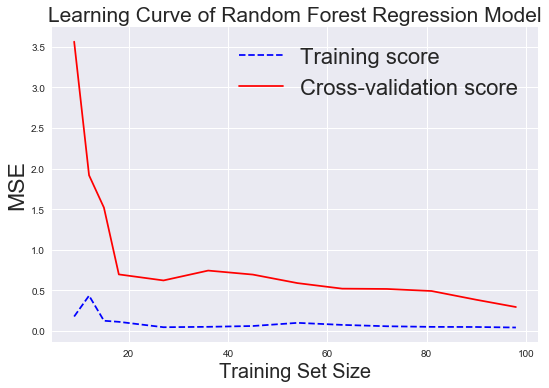

In [13]:
plt.style.use('seaborn')
# Plot the learning curve

# Training set scores
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Test set scores
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color='b',  label="Training score")
plt.plot(train_sizes, test_mean, color="r", label="Cross-validation score")

# Draw bands
#plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="b",alpha = 0.5)
#plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="r", alpha = 0.1)
    # Honestly, I don't know how to interpret the error bars on a learning curve, so I am dropping them from the figure
    # It returned a negative MSE. 
    
# Create plot
plt.title("Learning Curve of Random Forest Regression Model", Fontsize = 21)
plt.xlabel("Training Set Size", fontsize = 20), plt.ylabel("MSE", fontsize = 23)
plt.legend(loc="best", fontsize = 22)
plt.tight_layout()
plt.show()

In [14]:
rf_optimized.score(X_test,y_test)
# score the optimized model on the final test data. 

0.94235340890029884

In [15]:
rf_predict = rf_optimized.predict(X_test)
rf_train = rf_optimized.predict(X_train)
# predict data for comparision plot

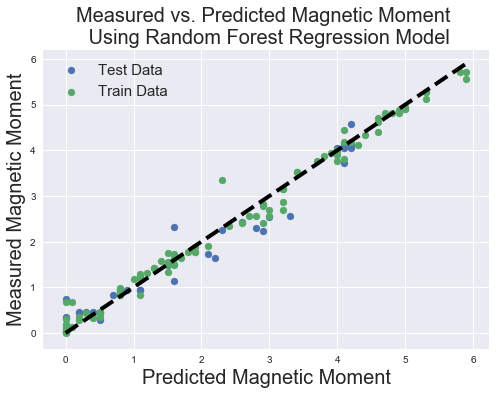

In [16]:
plt.style.use('seaborn')
# Compare measured and predicted values

fig, ax = plt.subplots()
plt.scatter(x=y_test, y=rf_predict, label = 'Test Data') # test data
plt.scatter(x=y_train, y=rf_train, label = 'Train Data') # train data

ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4) # line showing perfect prediction

plt.title('Measured vs. Predicted Magnetic Moment \n Using Random Forest Regression Model', fontsize=20)
ax.set_xlabel('Predicted Magnetic Moment', fontsize = 20)
ax.set_ylabel('Measured Magnetic Moment', fontsize = 20)
plt.legend(loc = "upper left", fontsize = 15)

plt.show()